In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
posterior_dir = "posterior_estimates/"


state_names = os.listdir(posterior_dir)

dataframes = []
for state in state_names:

    print(f"Loading {state}...")
    df_state = pd.read_csv(posterior_dir + state)
    df_state.iloc[:, 0][23] = r"$\alpha$"
    df_state.iloc[:, 0][24] = r"$\beta$"
    df_state.iloc[:, 0][27] = r"$\theta$"
    df_state["Federal state"] = state

    dataframes.append(df_state)

df = pd.concat(dataframes)
df

Loading Alabama.csv...
Loading Arizona.csv...
Loading Arkansas.csv...
Loading California.csv...
Loading Colorado.csv...
Loading Connecticut.csv...
Loading Delaware.csv...
Loading Florida.csv...
Loading Georgia.csv...
Loading Illinois.csv...
Loading Iowa.csv...
Loading Kansas.csv...
Loading Kentucky.csv...
Loading Louisiana.csv...
Loading Maryland.csv...
Loading Massachusetts.csv...
Loading Michigan.csv...
Loading Minnesota.csv...
Loading Mississippi.csv...
Loading Missouri.csv...
Loading Nevada.csv...
Loading New Jersey.csv...
Loading New Mexico.csv...
Loading North Carolina.csv...
Loading Ohio.csv...
Loading Oklahoma.csv...
Loading Oregon.csv...
Loading Pennsylvania.csv...
Loading Rhode Island.csv...
Loading South Carolina.csv...
Loading Tennessee.csv...
Loading Texas.csv...
Loading Virginia.csv...


<ipython-input-2-568bc670ee47>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state.iloc[:, 0][23] = r"$\alpha$"
<ipython-input-2-568bc670ee47>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state.iloc[:, 0][24] = r"$\beta$"
<ipython-input-2-568bc670ee47>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state.iloc[:, 0][27] = r"$\theta$"


,Unnamed: 0,Median,Mean,MAP,95-CI,Federal state
0,$t_1$,3.980,4.289,3.066,[0.288 - 10.042],Alabama.csv
1,$t_2$,15.214,15.228,15.059,[13.257 - 17.250],Alabama.csv
2,$t_3$,22.035,22.038,22.030,[20.005 - 24.113],Alabama.csv
3,$t_4$,54.585,54.550,54.674,[52.759 - 56.209],Alabama.csv
4,$\Delta t_1$,2.756,2.866,2.503,[1.360 - 5.000],Alabama.csv
...,...,...,...,...,...,...
25,$\gamma$,0.256,0.295,0.205,[0.127 - 0.698],Virginia.csv
26,$\eta$,0.387,0.399,0.376,[0.255 - 0.609],Virginia.csv
27,$\theta$,0.149,0.162,0.118,[0.069 - 0.300],Virginia.csv
28,$\delta$,0.033,0.037,0.026,[0.016 - 0.079],Virginia.csv


In [3]:
statistical_data_dir = "data/federal_state_data.csv"
df_statistical = pd.read_csv(statistical_data_dir, delimiter=",")

df_statistical.head()

,State,IQ,Average temperature [deg. F],Population density [people per square km],Avg. relative humidity [%],Median household income [1000 dollars per year],Fraction of citizens with Bachelor degree or higher [%],Republican-leaning fraction in 2020 election
0,Alabama,95.7,62.68,37,71.6,49.861,26.35,52
1,Arizona,97.4,65.97,23,38.5,59.246,30.18,40
2,Arkansas,97.5,60.09,22,70.9,47.062,23.34,46
3,California,95.5,61.17,97,61.0,75.277,35.00,30
4,Colorado,101.6,46.26,20,54.1,71.953,42.66,41


In [4]:
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.odr import *
import re

statistical_field_sorted = df_statistical.sort_values("State")
df_sorted = df.sort_values("Federal state")

def get_R_value(parameter, statistical_field, df_sorted, df_statistical_sorted, show=False):

    statistical_values = list(df_statistical_sorted[statistical_field])
    parameter_values = list(df_sorted[df_sorted.iloc[:, 0] == parameter]["MAP"])

    # Extract the uncertainties of the parameter estimates
    def CI_to_error(CIString):

        lower_bound, upper_bound = CIString.split(" - ")
        lower_bound = float(lower_bound[1:])
        upper_bound = float(upper_bound[:-1])

        return lower_bound, upper_bound

    parameter_values_err = list(df_sorted[df_sorted.iloc[:, 0] == parameter]["95-CI"])
    parameter_values_err = list(map(lambda x: CI_to_error(x) , parameter_values_err))
    parameter_values_err = np.asarray(parameter_values_err).T

    # Linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(statistical_values, parameter_values)

    def model(p, x):
        a, b = p
        return a * x + b

    data = RealData(statistical_values,
                    parameter_values)

    odr = ODR(data, Model(model), beta0=[0., 1.])
    out = odr.run()
    #out.pprint()

    slope, intercept = out.beta
    del_slope, del_intercept = out.sd_beta

    if show:
        plt.errorbar(statistical_values, parameter_values, yerr=parameter_values_err, color="blue", ls="none",
                     fmt="x", capsize=5, label="Parameter estimates (MAP)")
        x_space = np.linspace(*plt.gca().get_xlim(), 2)

        plt.plot(x_space, x_space * slope + intercept, color="black", label="ODR")
        plt.fill_between(x_space, x_space * (slope - del_slope) + intercept, x_space * (slope + del_slope) + intercept,
                         color="black", alpha=0.3, label="1$\sigma$ confidence interval of ODR")

        plt.title(f"$R= ${rvalue:.3f}, $p=${pvalue:.3f}")
        plt.xlabel(statistical_field)
        plt.ylabel(parameter)
        plt.grid()
        plt.legend()

        # Clean parameter and statistical field name
        def clean_name(string):
            return re.sub(r'\W+', '', string)

        savename = f"posterior_correlations/{clean_name(parameter)}-{clean_name(statistical_field)}.pdf"

        plt.savefig(savename)
        plt.close()

    #print(f"corr: {rvalue:.3f}, p:{pvalue:.3f}")

    return rvalue, pvalue

In [5]:
from itertools import product
statistical_fields = statistical_field_sorted.columns.tolist()[1:]
statistical_fields_short = [
    "IQ",
    "Temperature",
    "Population density",
    "Rel. humidity",
    "Income",
    "Education",
    "Republican-leaning"
]

parameters = df_sorted.iloc[:, 0].unique().tolist()

combinations = list(product(parameters, statistical_fields))

r_array = []
p_array = []

for i, (param, statistical_f) in enumerate(combinations):

    if i % 10 == 0:
        print(f"{param}, {statistical_f}, number {i+1}/{len(combinations)}")

    show=True
    r, p = get_R_value(param, statistical_f, df_sorted, statistical_field_sorted, show=show)
    r_array.append(r)
    p_array.append(p)

r_array = np.asarray(r_array)
p_array = np.asarray(p_array)

$t_1$, IQ, number 1/210
$d$, Avg. relative humidity [%], number 11/210
$\delta$, Republican-leaning fraction in 2020 election, number 21/210
$\eta$, Population density [people per square km], number 31/210
$\gamma$, Fraction of citizens with Bachelor degree or higher [%], number 41/210
$\alpha$, Average temperature [deg. F], number 51/210
$\sigma_I$, Median household income [1000 dollars per year], number 61/210
$D_D$, IQ, number 71/210
$D_I$, Avg. relative humidity [%], number 81/210
$\phi_D$, Republican-leaning fraction in 2020 election, number 91/210
$\phi_I$, Population density [people per square km], number 101/210
$\sigma_D$, Fraction of citizens with Bachelor degree or higher [%], number 111/210
$f_I$, Average temperature [deg. F], number 121/210
$t_2$, Median household income [1000 dollars per year], number 131/210
$t_4$, IQ, number 141/210
$\Delta t_1$, Avg. relative humidity [%], number 151/210
$\Delta t_3$, Republican-leaning fraction in 2020 election, number 161/210
$\lambd

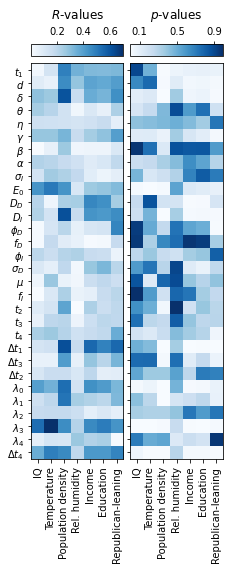

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(1*4.7747, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 cbar_location="top",
                  cbar_mode="each",
                  cbar_size="3%",
                  cbar_pad="2%"
                 )

ax1 = grid[0]
ax2 = grid[1]

#####
r_array = np.abs(r_array.reshape(len(parameters), len(statistical_fields)))
p_array = p_array.reshape(len(parameters), len(statistical_fields))

im1 = ax1.imshow(r_array, cmap="Blues", aspect="auto")
im2 = ax2.imshow(p_array, cmap="Blues", aspect="auto")

ax1.set_title("$R$-values", pad=45)
ax2.set_title("$p$-values", pad=45)

ax2.set_yticks(np.arange(len(parameters)))
ax2.set_yticklabels(parameters)

ax1.set_xticks(np.arange(len(statistical_fields)))
ax1.set_xticklabels(statistical_fields_short, rotation = 90)
ax2.set_xticks(np.arange(len(statistical_fields)))
ax2.set_xticklabels(statistical_fields_short, rotation = 90)

cbar1 = grid.cbar_axes[0].colorbar(im1)
cbar2 = grid.cbar_axes[1].colorbar(im2)

cbar1.set_ticks([0.2, 0.4, 0.6])
cbar2.set_ticks([0.1, 0.5, 0.9])
plt.tight_layout()
plt.savefig("test.pdf")